In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

def fetch_stock_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    return stock_data

def preprocess_data(data):
    data["Return_6months"] = (data["Adj Close"] / data["Adj Close"].shift(126) - 1) * 100
    data["Return_3months"] = (data["Adj Close"] / data["Adj Close"].shift(63) - 1) * 100
    data["Return_1month"] = (data["Adj Close"] / data["Adj Close"].shift(21) - 1) * 100
    data["Return_1week"] = (data["Adj Close"] / data["Adj Close"].shift(5) - 1) * 100
    data["Return_1day"] = (data["Adj Close"] / data["Adj Close"].shift(1) - 1) * 100

    # Drop NaN values
    data = data.dropna()

    return data

# Fetch NIFTY50 stock data
nifty50_symbols = [
    "BHARTIARTL.NS", "RELIANCE.NS", "TECHM.NS", "COALINDIA.NS", "INDUSINDBK.NS", "BAJAJ-AUTO.NS", "CIPLA.NS",
    "TCS.NS", "BAJAJFINSV.NS", "NTPC.NS", "TATASTEEL.NS", "ULTRACEMCO.NS", "KOTAKBANK.NS", "LT.NS", "MARUTI.NS",
    "NESTLEIND.NS", "HINDALCO.NS", "HDFCLIFE.NS", "WIPRO.NS", "TATACONSUM.NS", "BAJFINANCE.NS", "TITAN.NS",
    "BRITANNIA.NS", "ONGC.NS", "HEROMOTOCO.NS", "APOLLOHOSP.NS", "ITC.NS", "ADANIENT.NS", "LTIM.NS"
]

nifty50_data = {}
start_date = "2010-01-01"
end_date = "2024-01-01"

for symbol in nifty50_symbols:
    nifty50_data[symbol] = fetch_stock_data(symbol, start_date, end_date)

# Display trade data storage
trade_data = []

# Implement the trading strategy
for symbol, stock_data in nifty50_data.items():
    processed_data = preprocess_data(stock_data)

    # Initialize capital for each stock
    initial_capital = 10000
    capital = initial_capital

    # Track number of shares bought and selling state
    shares_held = 0
    in_trade = False

    # Iterate over the processed data
    for index, row in processed_data.iterrows():
        if (
            row["Return_6months"] > 0 and
            row["Return_3months"] > 0 and
            row["Return_1month"] > 0 and
            row["Return_1week"] > 0 and
            row["Return_1day"] > 0
        ):
            # Buy shares if not in a trade
            if not in_trade:
                shares_to_buy = int(capital / row["Close"])
                if shares_to_buy > 0:
                    capital -= shares_to_buy * row["Close"]
                    trade_data.append({"Symbol": symbol, "Action": "Buy", "Date": index, "Price": row["Close"], "Shares": shares_to_buy, "Capital": capital, "Profit": 0, "Loss": 0})
                    shares_held = shares_to_buy
                    in_trade = True

        elif in_trade and (row["Close"] - trade_data[-1]["Price"]) / trade_data[-1]["Price"] >= 0.10:
            # Sell shares if in a trade and there is a minimum increase of 20% or more
            capital += shares_held * row["Close"]
            profit_loss = (row["Close"] - trade_data[-1]["Price"]) * shares_held
            if profit_loss > 0:
                trade_data[-1]["Profit"] = profit_loss  # Update profit during sell action
            else:
                trade_data[-1]["Loss"] = abs(profit_loss)  # Update loss during sell action
            trade_data.append({"Symbol": symbol, "Action": "Sell", "Date": index, "Price": row["Close"], "Shares": shares_held, "Capital": capital, "Profit": 0, "Loss": 0})
            shares_held = 0
            in_trade = False

    # Keep remaining shares in hold at the end of the trade
    if in_trade:
        # During hold action, do not calculate profit or loss
        trade_data.append({"Symbol": symbol, "Action": "Hold", "Date": processed_data.index[-1], "Shares": shares_held, "Capital": capital, "Profit": 0, "Loss": 0})

# Display trade data
trade_df = pd.DataFrame(trade_data)
print(trade_df)

# Write trade data to CSV
trade_df.to_csv("trade_data.csv", index=False)

# Display the final capital and percentage return for each stock
total_initial_capital = len(nifty50_symbols) * initial_capital
total_final_capital = 0

for symbol in nifty50_data.keys():
    final_capital = initial_capital + trade_df[trade_df["Symbol"] == symbol]["Profit"].sum() - trade_df[trade_df["Symbol"] == symbol]["Loss"].sum()
    total_final_capital += final_capital
    percentage_return = (final_capital - initial_capital) / initial_capital * 100
    print(f"Symbol: {symbol}, Final Capital: {final_capital:.2f}, Percentage Return: {percentage_return:.2f}%")

# Display the total percentage return across all stocks
total_percentage_return = (total_final_capital - total_initial_capital) / total_initial_capital * 100
print("total_initial_capital: ", total_initial_capital)
print("total_final_capital: ", total_final_capital)
print(f"Total Percentage Return Across All Stocks: {total_percentage_return:.2f}%")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

C:\Users\HP\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


Maximum Drawdown: 0.00%
Volatility (Standard Deviation): 1195484.25%
Average Profit: 8203.48
Average Loss: nan
Risk-Reward Ratio: nan
Winning Percentage: 47.12%
Sharpe Ratio: 2.13
Sortino Ratio: nan
Calmar Ratio: inf


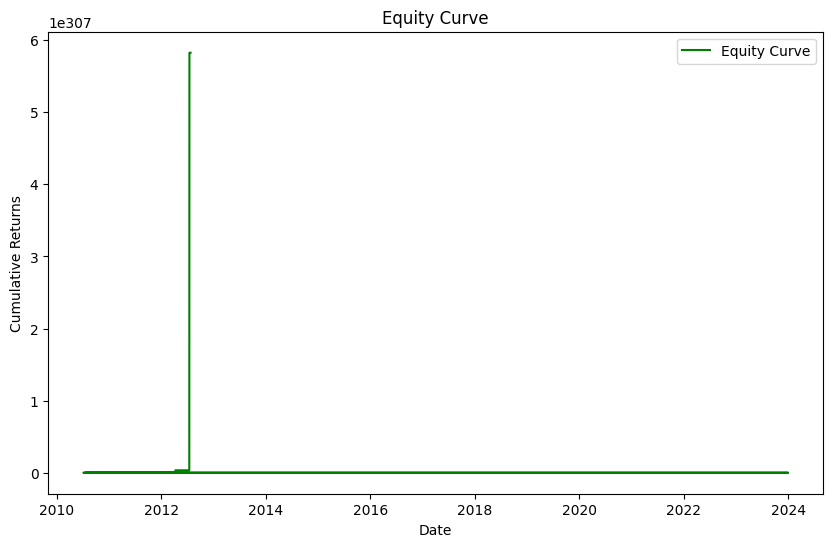

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assume 'trade_df' contains the trade data as a DataFrame

# 1. Calculate Maximum Drawdown
cumulative_returns = (1 + (trade_df['Profit'] + trade_df['Loss']) / trade_df['Capital']).cumprod()
peak_value = cumulative_returns.expanding(min_periods=1).max()
drawdown = (cumulative_returns - peak_value) / peak_value
max_drawdown = drawdown.min()

print(f"Maximum Drawdown: {max_drawdown:.2%}")

# 2. Calculate Volatility (Standard Deviation)
volatility = (trade_df['Profit'] + trade_df['Loss']).std()
print(f"Volatility (Standard Deviation): {volatility:.2%}")

# 3. Calculate Risk-Reward Ratio
average_profit = trade_df[trade_df["Profit"] > 0]["Profit"].mean()
average_loss = trade_df[trade_df["Loss"] > 0]["Loss"].mean()
risk_reward_ratio = average_profit / average_loss

print(f"Average Profit: {average_profit:.2f}")
print(f"Average Loss: {average_loss:.2f}")
print(f"Risk-Reward Ratio: {risk_reward_ratio:.2f}")

# 4. Winning Percentage
winning_percentage = len(trade_df[trade_df["Profit"] > 0]) / len(trade_df) * 100
print(f"Winning Percentage: {winning_percentage:.2f}%")

# 5. Sharpe Ratio
risk_free_rate = 0.02  # Assume a risk-free rate for simplicity
daily_returns = (trade_df['Profit'] + trade_df['Loss']) / trade_df['Capital']
sharpe_ratio = np.sqrt(252) * (daily_returns.mean() - risk_free_rate) / daily_returns.std()

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# 6. Sortino Ratio
downside_returns = trade_df[trade_df['Loss'] > 0]['Loss']
sortino_ratio = np.sqrt(252) * (daily_returns.mean() - risk_free_rate) / downside_returns.std()

print(f"Sortino Ratio: {sortino_ratio:.2f}")

# 7. Calmar Ratio
average_annual_return = (cumulative_returns.iloc[-1] ** (252 / len(cumulative_returns))) - 1
calmar_ratio = average_annual_return / abs(max_drawdown)

print(f"Calmar Ratio: {calmar_ratio:.2f}")

# 8. Visualization: Equity Curve
plt.figure(figsize=(10, 6))
plt.plot(trade_df['Date'], cumulative_returns, label='Equity Curve', color='green')
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()
